### Loading Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

In [ ]:
df = pd.read_csv("umich_train_data.csv", header=None, delimiter='\t', quoting=3)
df.columns = ['sentiment','text']
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.shape

(30459, 2)

In [ ]:
df.head()

,sentiment,text
0,0,The history here goes back to the summer of 19...
1,0,American Express customer service SUCKS...
2,1,"Wow, having XP on my MacBook would be awesome..."
3,1,"I love paris hilton, britney spears and jessic..."
4,1,"The Da Vinci Code was awesome, I can't wait to..."


### Data Visualization and Preprocessing

In [ ]:
df.head()

,sentiment,text
0,0,The history here goes back to the summer of 19...
1,0,American Express customer service SUCKS...
2,1,"Wow, having XP on my MacBook would be awesome..."
3,1,"I love paris hilton, britney spears and jessic..."
4,1,"The Da Vinci Code was awesome, I can't wait to..."


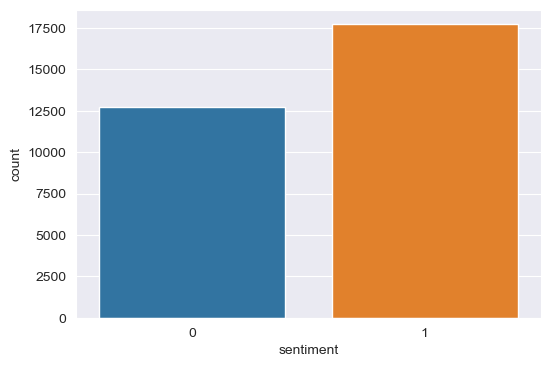

In [ ]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(x=df.sentiment, data=df)
plt.show()

In [ ]:
df.isna().sum() # Checking for nan Values

sentiment    0
text         0
dtype: int64

### Cleaning the corpus

In [ ]:
def clean_text(text):
    text = str(text).lower() ## Make text lowercase
    text = re.sub('\[.*?\]', '', text) ## remove any sequence of characters in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) ## remove links
    text = re.sub('<.*?>+', '', text) ## remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) ## remove punctuation
    text = re.sub('\n', '', text) ## remove newline characters
    text = re.sub('\w*\d\w*', '', text) ## remove words containing numbers
    return text

In [ ]:
df['text_clean'] = df['text'].apply(clean_text)
df.head()

,sentiment,text,text_clean
0,0,The history here goes back to the summer of 19...,the history here goes back to the summer of w...
1,0,American Express customer service SUCKS...,american express customer service sucks
2,1,"Wow, having XP on my MacBook would be awesome...",wow having xp on my macbook would be awesome
3,1,"I love paris hilton, britney spears and jessic...",i love paris hilton britney spears and jessica...
4,1,"The Da Vinci Code was awesome, I can't wait to...",the da vinci code was awesome i cant wait to r...


In [ ]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['text_clean'] = df['text_clean'].apply(remove_stopwords)
df.head()

,sentiment,text,text_clean
0,0,The history here goes back to the summer of 19...,history goes back summer san francisco giants...
1,0,American Express customer service SUCKS...,american express customer service sucks
2,1,"Wow, having XP on my MacBook would be awesome...",wow xp macbook would awesome
3,1,"I love paris hilton, britney spears and jessic...",love paris hilton britney spears jessica simpson
4,1,"The Da Vinci Code was awesome, I can't wait to...",da vinci code awesome cant wait read


In [ ]:
df = df.drop('text', axis=1)
df = df.rename(columns={'text_clean': 'text'})
df.head()

,sentiment,text
0,0,history goes back summer san francisco giants...
1,0,american express customer service sucks
2,1,wow xp macbook would awesome
3,1,love paris hilton britney spears jessica simpson
4,1,da vinci code awesome cant wait read


In [ ]:
df2 = df.copy()

### WordCloud

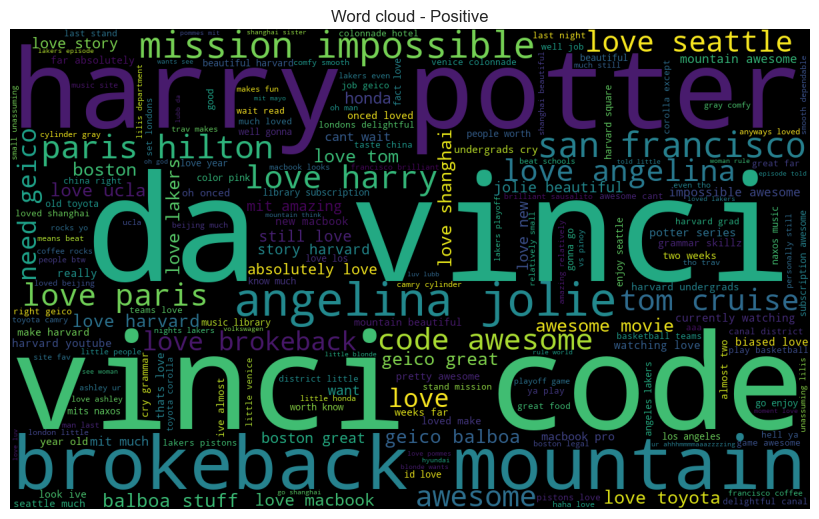

In [ ]:
dfs = df.sample(frac=0.1, random_state=42)

wrds=''
for msg in dfs[dfs['sentiment']==1]['text']:
    msg=msg.split()
    for words in msg:
        wrds = wrds+words+' '

wcloud = WordCloud(width=1200, height=720,random_state=101).generate(wrds)

plt.figure( figsize=(10,5), facecolor='w')
plt.imshow(wcloud)
plt.title('Word cloud - Positive')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

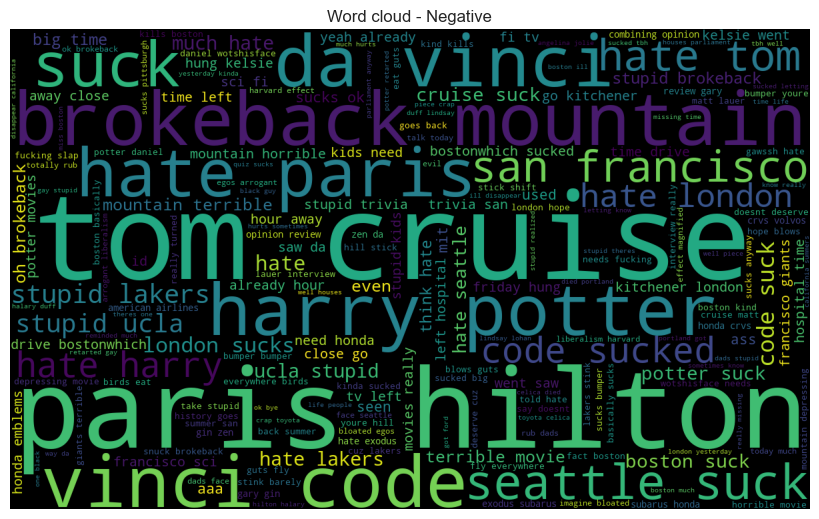

In [ ]:
wrds=''
for msg in dfs[dfs['sentiment']==0]['text']:
    msg=msg.split()
    for words in msg:
        wrds = wrds+words+' '

wcloud = WordCloud(width=1200, height=720,random_state=101).generate(wrds)

plt.figure( figsize=(10,5), facecolor='w')
plt.imshow(wcloud)
plt.title('Word cloud - Negative')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Number of words in each text**

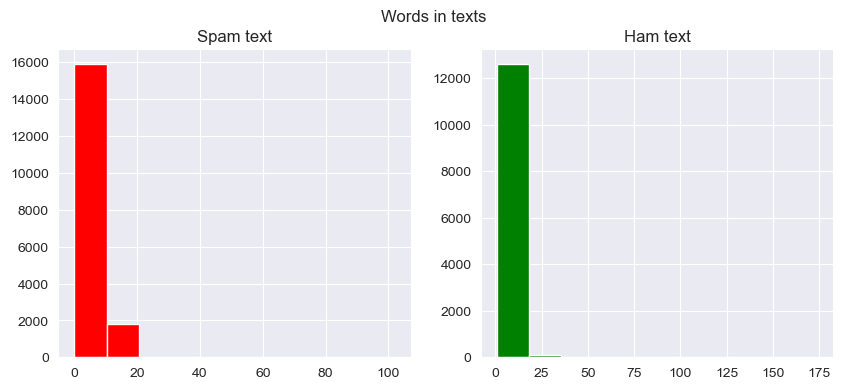

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10, 4))
text_len=df[df['sentiment']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Spam text')
text_len=df[df['sentiment']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Ham text')
fig.suptitle('Words in texts')
plt.show()

### Word Frequency

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

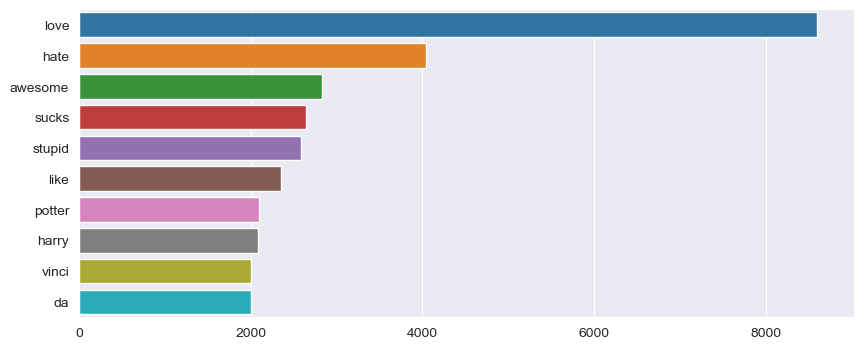

In [ ]:
plt.figure(figsize = (10,4))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
plt.show()

**Bigram Analysis**

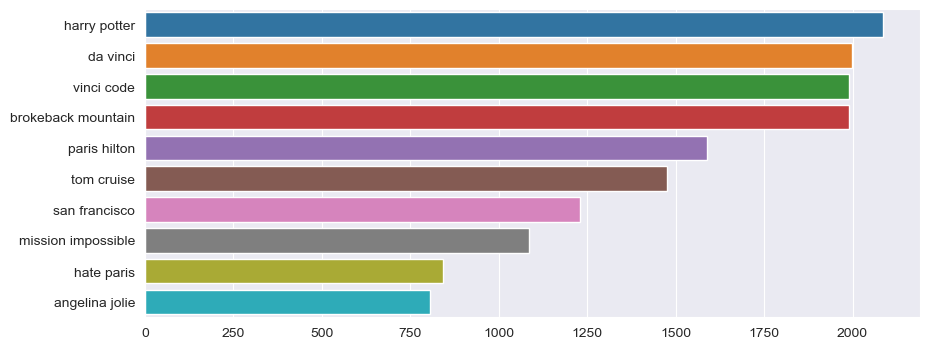

In [ ]:
plt.figure(figsize = (10,4))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.show()

**Trigram Analysis**

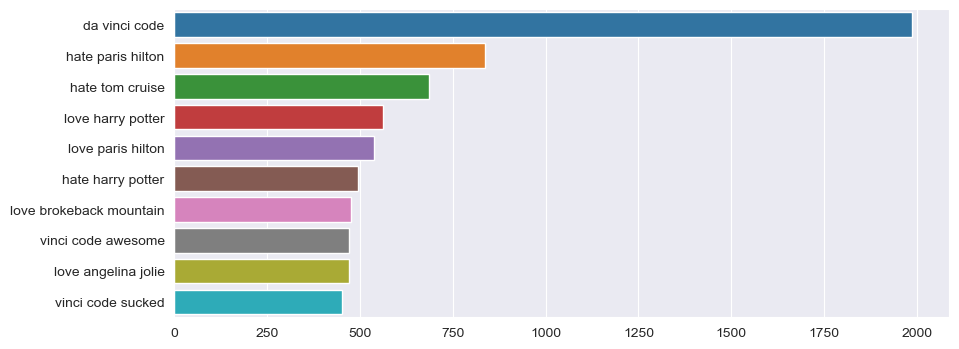

In [ ]:
plt.figure(figsize = (10,4))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))
plt.show()

### Lemmatizer

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemm_text(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return text

In [ ]:
df['text_clean'] = df['text'].apply(lemm_text)
df.head()

,sentiment,text,text_clean
0,0,history goes back summer san francisco giants...,history go back summer san francisco giant te...
1,0,american express customer service sucks,american express customer service suck
2,1,wow xp macbook would awesome,wow xp macbook would awesome
3,1,love paris hilton britney spears jessica simpson,love paris hilton britney spear jessica simpson
4,1,da vinci code awesome cant wait read,da vinci code awesome cant wait read


In [ ]:
df = df.drop('text', axis=1)
df = df.rename(columns={'text_clean':'text'})
df2 = df.copy()

### Count Vectorizer

In [ ]:
df = df2.copy()

In [ ]:
X = df.text
y = df['sentiment']

In [ ]:
X.shape, y.shape

((30459,), (30459,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english', min_df=5)

In [ ]:
vect.fit(X_train)

CountVectorizer(min_df=5, stop_words='english')

In [ ]:
X_traint = vect.transform(X_train)
X_testt = vect.transform(X_test)

print(X_traint.shape, X_testt.shape)

(21321, 1061) (9138, 1061)


In [ ]:
vect.get_feature_names_out()[0:10]

array(['aaa', 'aback', 'able', 'absolutely', 'academy', 'accent',
       'acceptable', 'accord', 'aching', 'acknowledged'], dtype=object)

#### Tf-IDF

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times.

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

Let's go ahead and see how we can do this in SciKit Learn:

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(X_traint)
X_traint_tfidf = tfidf_transformer.transform(X_traint).toarray()
X_testt_tfidf = tfidf_transformer.transform(X_testt).toarray()
print(X_traint_tfidf[20])

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(X_traint_tfidf.shape)
print(type(X_traint_tfidf))

(21321, 1061)
<class 'numpy.ndarray'>


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [ ]:
rfc = RandomForestClassifier()

params = {'n_estimators':sp_randint(50, 300),
          'max_features':sp_randint(100, 1061),
          'max_depth': sp_randint(1, 20),
          'min_samples_leaf': sp_randint(1, 50)}

rs = RandomizedSearchCV(rfc, param_distributions=params, n_iter=20,
    scoring='roc_auc', cv=3)

#rs.fit(X_traint_tfidf, y_train)

#rs.best_params_

{'max_depth': 19,
 'max_features': 875,
 'min_samples_leaf': 12,
 'n_estimators': 286}

In [ ]:
best_params_ = {'max_depth': 19, 'max_features': 875,
 'min_samples_leaf': 12, 'n_estimators': 286}

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

rfc = RandomForestClassifier(**best_params_)

rfc.fit(X_traint_tfidf, y_train)

y_train_pred = rfc.predict(X_traint_tfidf)
y_train_prob = rfc.predict_proba(X_traint_tfidf)[:,1]

print('Confusion Matrix: ', '\n', confusion_matrix(y_train, y_train_pred))

print('Accuracy of Train: ',  accuracy_score(y_train, y_train_pred))
print('AUC of Train: ', roc_auc_score(y_train, y_train_prob))

y_test_pred = rfc.predict(X_testt_tfidf)
y_test_prob = rfc.predict_proba(X_testt_tfidf)[:,1]

print('\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_test_pred))

print('Accuracy of Test: ',  accuracy_score(y_test, y_test_pred))
print('AUC of Test: ', roc_auc_score(y_test, y_test_prob))

Confusion Matrix:  
 [[ 8762   159]
 [   28 12372]]
Accuracy of Train:  0.9912293044416303
AUC of Train:  0.9998052303191817


Confusion Matrix:  
 [[3750   69]
 [  21 5298]]
Accuracy of Test:  0.990151017728168
AUC of Test:  0.9994735458772472


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
thresholds[0] = thresholds[0]-1

In [ ]:
thresh = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'thresh':thresholds})

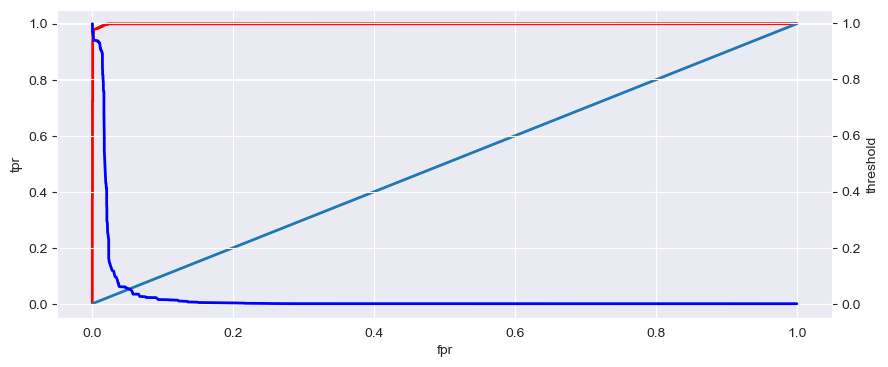

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(fpr, tpr, lw=2, color='r')
ax.plot(fpr, fpr, lw=2)
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')

ax2 = ax.twinx()
ax2.plot(fpr, thresholds, lw=2, color='b')
ax2.set_ylabel('threshold')
plt.show()

### Sentiment score from NLTK library

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\regiv\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
dfs = df.copy()

In [ ]:
def sentiment_analyze(text):
    return sia.polarity_scores(text)

dfs['sentiment'] = dfs['text'].apply(sentiment_analyze)
dfs = dfs['sentiment'].apply(pd.Series)
dfs = dfs[['pos']]

In [ ]:
df = pd.concat([df, dfs], axis=1)

In [ ]:
df.head()

,sentiment,text,pos
0,0,history go back summer san francisco giant te...,0.000
1,0,american express customer service suck,0.000
2,1,wow xp macbook would awesome,0.840
3,1,love paris hilton britney spear jessica simpson,0.412
4,1,da vinci code awesome cant wait read,0.406


In [ ]:
df['pos'] = np.where(df['pos']>=0.5, 1, 0)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(df['sentiment'], df['pos']))
print('\n')
print('Accuracy comparing actual sentiment score and score from NLTK library')
print(accuracy_score(df['sentiment'], df['pos']))

[[12718    22]
 [ 6134 11585]]


Accuracy comparing actual sentiment score and score from NLTK library
0.7978922485964739
